Resnet 18 for freiburg dataset

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import torch.optim as optim

In [ ]:
def load_data(path, test_split, val_split, batch_size, input_size):
    
    transform_dict={'src':transforms.Compose([transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip(),
                      transforms.RandomRotation(15),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])}
    
    data1 = datasets.ImageFolder(root=path,transform =transform_dict['src'])
    test_size=int(len(data1)*test_split)
    val_size=int(len(data1)*val_split)
    train_size=len(data1)-val_size-test_size
    train_dataset,test_dataset,val_dataset=td.random_split(data1,[train_size,test_size,val_size])
    data_loader_train=td.DataLoader(train_dataset,batch_size,shuffle=True,drop_last=False,num_workers=0)
    data_loader_test=td.DataLoader(test_dataset,batch_size,shuffle=True,drop_last=False,num_workers=0)
    data_loader_val=td.DataLoader(val_dataset,batch_size,shuffle=True,drop_last=False,num_workers=0)  
    return data_loader_train, data_loader_test, data_loader_val

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_loader,test_loader,val_loader=load_data(path=r'/content/drive/MyDrive/Project/Dataset/freiburg_dataset', 
                                              test_split=0.2,val_split= 0.2,batch_size=32, input_size=[256,256])

In [ ]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = dataiter.next()
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

In [ ]:
plot_data_loader(train_loader,(2,2))

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18',pretrained=True)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
def train( model, train_loader,val_loader, criterion, optimizer,num_epochs):
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      print("Device: {}".format(device))
      model.to(device)
      total_steps = len(train_loader)
      t1 = time.time()
      accuracy1 = []
      loss1 = []
      val_acc=[]
      val_loss=[]
      for epoch in range(num_epochs):
          accu = 0
          lss = 0
          val_accu=0
          valid_loss=0
          for i,data in enumerate(train_loader):
              images, labels = data[0].to(device), data[1].to(device)
              # Forward pass
              outputs = model(images)
              loss = criterion(outputs, labels)
              # Backprop and optimisation
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              # Train accuracy
              total = labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == labels).sum().item()
              accu += (correct / total) * 100
              lss += loss.item()
          model.eval()  
          for i, data in enumerate(val_loader):
              val_images, val_labels = data[0].to(device), data[1].to(device)
              outputs = model(val_images)
              loss = criterion(outputs, val_labels)
              # Val accuracy
              total = val_labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == val_labels).sum().item()
              val_accu += (correct / total) * 100
              valid_loss += loss.item()
          val_acc.append(val_accu/len(val_loader))
          val_loss.append(valid_loss/len(val_loader))
          accuracy1.append(accu/len(train_loader))
          loss1.append(lss/len(train_loader))
          
          print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Loss : {:.4f}, Validation Accuracy : {:.2f}%,'.format(epoch + 1, num_epochs,lss/len(train_loader) ,accu/len(train_loader), valid_loss/len(val_loader), val_accu/len(val_loader)))
      print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
      return model, accuracy1, loss1,val_acc,val_loss

In [ ]:
model,accuracy1,loss1, val_acc1, val_loss1=train( model, train_loader,val_loader, criterion, optimizer,num_epochs=50)

Device: cuda:0
Epoch [1/50], Loss: 2.4869, Accuracy: 36.57%, Validation Loss : 4.1699, Validation Accuracy : 22.90%,
Epoch [2/50], Loss: 3.3504, Accuracy: 7.87%, Validation Loss : 3.0725, Validation Accuracy : 7.81%,
Epoch [3/50], Loss: 3.0906, Accuracy: 7.67%, Validation Loss : 3.0565, Validation Accuracy : 8.08%,
Epoch [4/50], Loss: 3.0678, Accuracy: 6.90%, Validation Loss : 3.1046, Validation Accuracy : 5.17%,
Epoch [5/50], Loss: 3.0653, Accuracy: 7.22%, Validation Loss : 3.0561, Validation Accuracy : 5.53%,
Epoch [6/50], Loss: 3.0499, Accuracy: 9.94%, Validation Loss : 3.0273, Validation Accuracy : 7.81%,
Epoch [7/50], Loss: 2.9711, Accuracy: 13.15%, Validation Loss : 2.9658, Validation Accuracy : 9.15%,
Epoch [8/50], Loss: 2.9578, Accuracy: 11.77%, Validation Loss : 3.0309, Validation Accuracy : 11.55%,
Epoch [9/50], Loss: 2.8759, Accuracy: 14.53%, Validation Loss : 2.8693, Validation Accuracy : 12.74%,
Epoch [10/50], Loss: 2.8120, Accuracy: 15.99%, Validation Loss : 2.8362, Valid

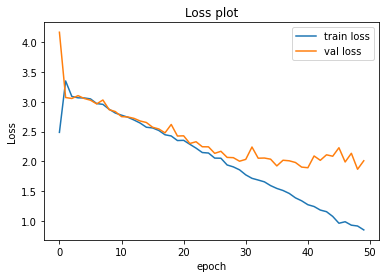

In [ ]:
import matplotlib.pyplot as plt

num_epochs= 50
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
epochs = [i for i in range(num_epochs)]

plt.plot(loss1,label='train loss')
plt.plot(val_loss1,label='val loss')
    
plt.legend()


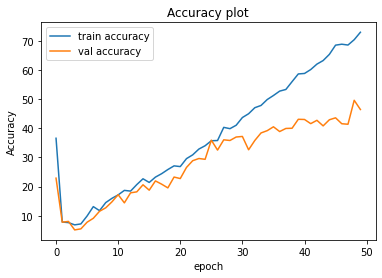

In [ ]:
import matplotlib.pyplot as plt

num_epochs= 50
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(accuracy1,label='train accuracy')
plt.plot(val_acc1,label='val accuracy')    
plt.legend()


In [ ]:
model.eval() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

Test Accuracy of the model on the 815 test images: 42.82208588957055 %


In [ ]:
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/model_resnet1.pt')
#model = torch.load('/content/drive/MyDrive/Colab Notebooks')
#model.eval()

Resnet-18 for Grocery dataset

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_data_grocery_store(path, batch_size, input_size):
    
    transform_dict={'src':transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomRotation(5),transforms.RandomHorizontalFlip(), transforms.Resize(256),
                                              transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])}
    data1 = datasets.ImageFolder(root=path,transform=transform_dict['src'])
    data_loader=td.DataLoader(data1,batch_size,shuffle=True,drop_last=False,num_workers=0)  
    return data_loader

train_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Train', batch_size=16, input_size=[224,224])
test_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Test', batch_size=16, input_size=[224,224])
val_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Val', batch_size=16, input_size=[224,224])

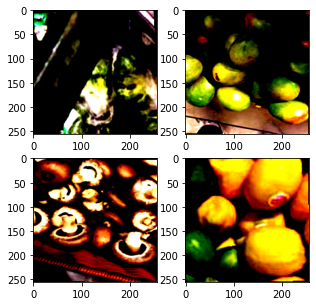

In [ ]:
plot_data_loader(train_loader2,(2,2))

In [ ]:
model2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18')
optimizer2 = torch.optim.Adam(model2.parameters())
criterion2 = nn.CrossEntropyLoss()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


In [ ]:
def train( model, train_loader,val_loader, criterion, optimizer,num_epochs):
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      print("Device: {}".format(device))
      model.to(device)
      total_steps = len(train_loader)
      t1 = time.time()
      accuracy1 = []
      loss1 = []
      val_acc=[]
      val_loss=[]
      for epoch in range(num_epochs):
          accu = 0
          lss = 0
          val_accu=0
          valid_loss=0
          for i,data in enumerate(train_loader):
              images, labels = data[0].to(device), data[1].to(device)
              # Forward pass
              outputs = model(images)
              loss = criterion(outputs, labels)
              # Backprop and optimisation
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              # Train accuracy
              total = labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == labels).sum().item()
              accu += (correct / total) * 100
              lss += loss.item()
          model.eval()  
          for i, data in enumerate(val_loader):
              val_images, val_labels = data[0].to(device), data[1].to(device)
              outputs = model(val_images)
              loss = criterion(outputs, val_labels)
              # Val accuracy
              total = val_labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == val_labels).sum().item()
              val_accu += (correct / total) * 100
              valid_loss += loss.item()
          val_acc.append(val_accu/len(val_loader))
          val_loss.append(valid_loss/len(val_loader))
          accuracy1.append(accu/len(train_loader))
          loss1.append(lss/len(train_loader))
          
          print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Loss : {:.4f}, Validation Accuracy : {:.2f}%,'.format(epoch + 1, num_epochs,lss/len(train_loader) ,accu/len(train_loader), valid_loss/len(val_loader), val_accu/len(val_loader)))
      print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
      return model, accuracy1, loss1,val_acc,val_loss

In [ ]:
model2,accuracy2,loss2,val_acc2,val_loss2=train(model2, train_loader2,val_loader2, criterion2, optimizer2,num_epochs=50)

Device: cuda:0
Epoch [1/50], Loss: 2.9767, Accuracy: 20.66%, Validation Loss : 2.9045, Validation Accuracy : 18.43%,
Epoch [2/50], Loss: 2.6337, Accuracy: 23.12%, Validation Loss : 2.7036, Validation Accuracy : 21.72%,
Epoch [3/50], Loss: 2.2500, Accuracy: 29.68%, Validation Loss : 2.5333, Validation Accuracy : 23.68%,
Epoch [4/50], Loss: 1.9896, Accuracy: 35.58%, Validation Loss : 2.2944, Validation Accuracy : 28.92%,
Epoch [5/50], Loss: 1.7719, Accuracy: 41.85%, Validation Loss : 2.1095, Validation Accuracy : 35.12%,
Epoch [6/50], Loss: 1.6188, Accuracy: 47.11%, Validation Loss : 1.8945, Validation Accuracy : 42.36%,
Epoch [7/50], Loss: 1.5305, Accuracy: 51.49%, Validation Loss : 2.0111, Validation Accuracy : 34.56%,
Epoch [8/50], Loss: 1.4297, Accuracy: 53.45%, Validation Loss : 1.7225, Validation Accuracy : 45.00%,
Epoch [9/50], Loss: 1.2989, Accuracy: 57.55%, Validation Loss : 1.6630, Validation Accuracy : 49.74%,
Epoch [10/50], Loss: 1.1917, Accuracy: 61.01%, Validation Loss : 1.

In [ ]:
torch.save(model2, 'model_resnet2.pt')
#model = torch.load('/content/drive/MyDrive/Colab Notebooks')
#model.eval()

[2.9767446172864815, 2.633742810079926, 2.2500466084793995, 1.9895801928482557, 1.7719093384711366, 1.6188164341606592, 1.5305267148896267, 1.4297426731178635, 1.2988917537425693, 1.1917353605753498, 1.1479333203874136, 1.0760974309554225, 1.0328884369840747, 0.9779310018608445, 0.8954793983384183, 0.820929124167091, 0.8957576537994962, 0.7818638239251939, 0.7576948365098551, 0.7290372863215836, 0.6867919025060377, 0.629752499198443, 0.6249683236115073, 0.5791299908765053, 0.588271680042932, 0.5395209572621082, 0.5435747630698117, 0.5050476529194337, 0.5256066215959819, 0.5227365136930817, 0.42526101063642846, 0.4083606225291365, 0.435263142994556, 0.39574725901413904, 0.4231879157749446, 0.40980615074697296, 0.3958160466955681, 0.3788858839359723, 0.33790272312532915, 0.32341320932793777, 0.359156576228806, 0.31289730163438145, 0.2979904953941801, 0.3179226836900374, 0.2988308644976075, 0.2984261832101957, 0.31760407018622283, 0.27598573782138136, 0.2629073494738948, 0.252370342992148

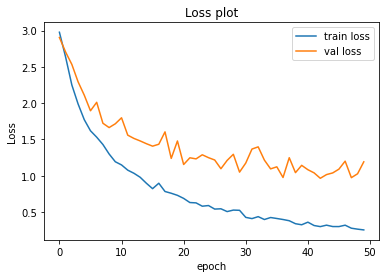

In [ ]:
import matplotlib.pyplot as plt

num_epochs= 30
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.plot(loss2,label='train loss')
plt.plot(val_loss2,label='val loss')
    
plt.legend()

print(loss2)

[20.656399521531103, 23.119766746411482, 29.676285885167466, 35.57864832535885, 41.84733851674641, 47.110496411483254, 51.48773923444976, 53.446471291866025, 57.55083732057416, 61.00852272727273, 62.301883971291865, 64.20828349282296, 65.40071770334927, 67.07535885167465, 69.4377990430622, 72.06190191387559, 70.465759569378, 74.67479066985646, 75.4971590909091, 76.54754784688994, 77.47084330143541, 79.8781399521531, 80.0613038277512, 81.0930023923445, 80.74162679425837, 81.91163277511961, 82.13965311004785, 84.0909090909091, 84.25538277511961, 83.59748803827752, 86.74491626794259, 87.58223684210526, 86.02347488038278, 87.032745215311, 87.19348086124401, 87.58223684210526, 87.5, 87.85511363636363, 89.70170454545455, 89.80263157894737, 88.69617224880383, 89.97084330143541, 90.56892942583731, 90.04934210526316, 90.72966507177033, 90.66985645933015, 90.0904605263158, 91.5968899521531, 92.35571172248804, 92.31459330143541]


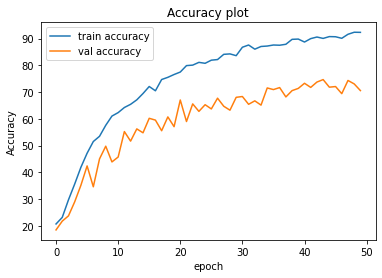

In [ ]:
import matplotlib.pyplot as plt

num_epochs= 30
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(accuracy2,label='train accuracy')
plt.plot(val_acc2, label='val accuracy')
    
plt.legend()

print(accuracy2)

In [ ]:
model2.eval() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader2:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

Test Accuracy of the model on the 2423 test images: 75.11349566652909 %
